## Importing the libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Bidirectional

import joblib

In [ ]:
# Order of dataframe for weather data:
# 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m'

## Importing and preparing the dataset

In [2]:
# TODO: Change location code to the location required to train on for LSTM time series weather forecasting
location_code = "ipoh"
hourly_dataframe = pd.read_csv(f'../../datasets/{location_code}/weather_data_hourly.csv')

In [3]:
hourly_dataframe.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,rain,pressure_msl,wind_speed_10m,wind_direction_10m
0,2009-12-31 16:00:00+00:00,23.382000,94.122230,22.382000,0.3,1009.5,3.758510,106.699326
1,2009-12-31 17:00:00+00:00,23.382000,94.122230,22.382000,0.0,1009.0,4.693825,94.398620
2,2009-12-31 18:00:00+00:00,23.581999,93.560814,22.481998,0.0,1008.7,4.680000,90.000000
3,2009-12-31 19:00:00+00:00,23.981998,90.782520,22.382000,0.2,1008.1,5.040000,90.000000
4,2009-12-31 20:00:00+00:00,23.632000,92.151920,22.282000,0.2,1007.7,3.758510,106.699326


In [4]:
hourly_dataframe.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m'],
      dtype='object')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

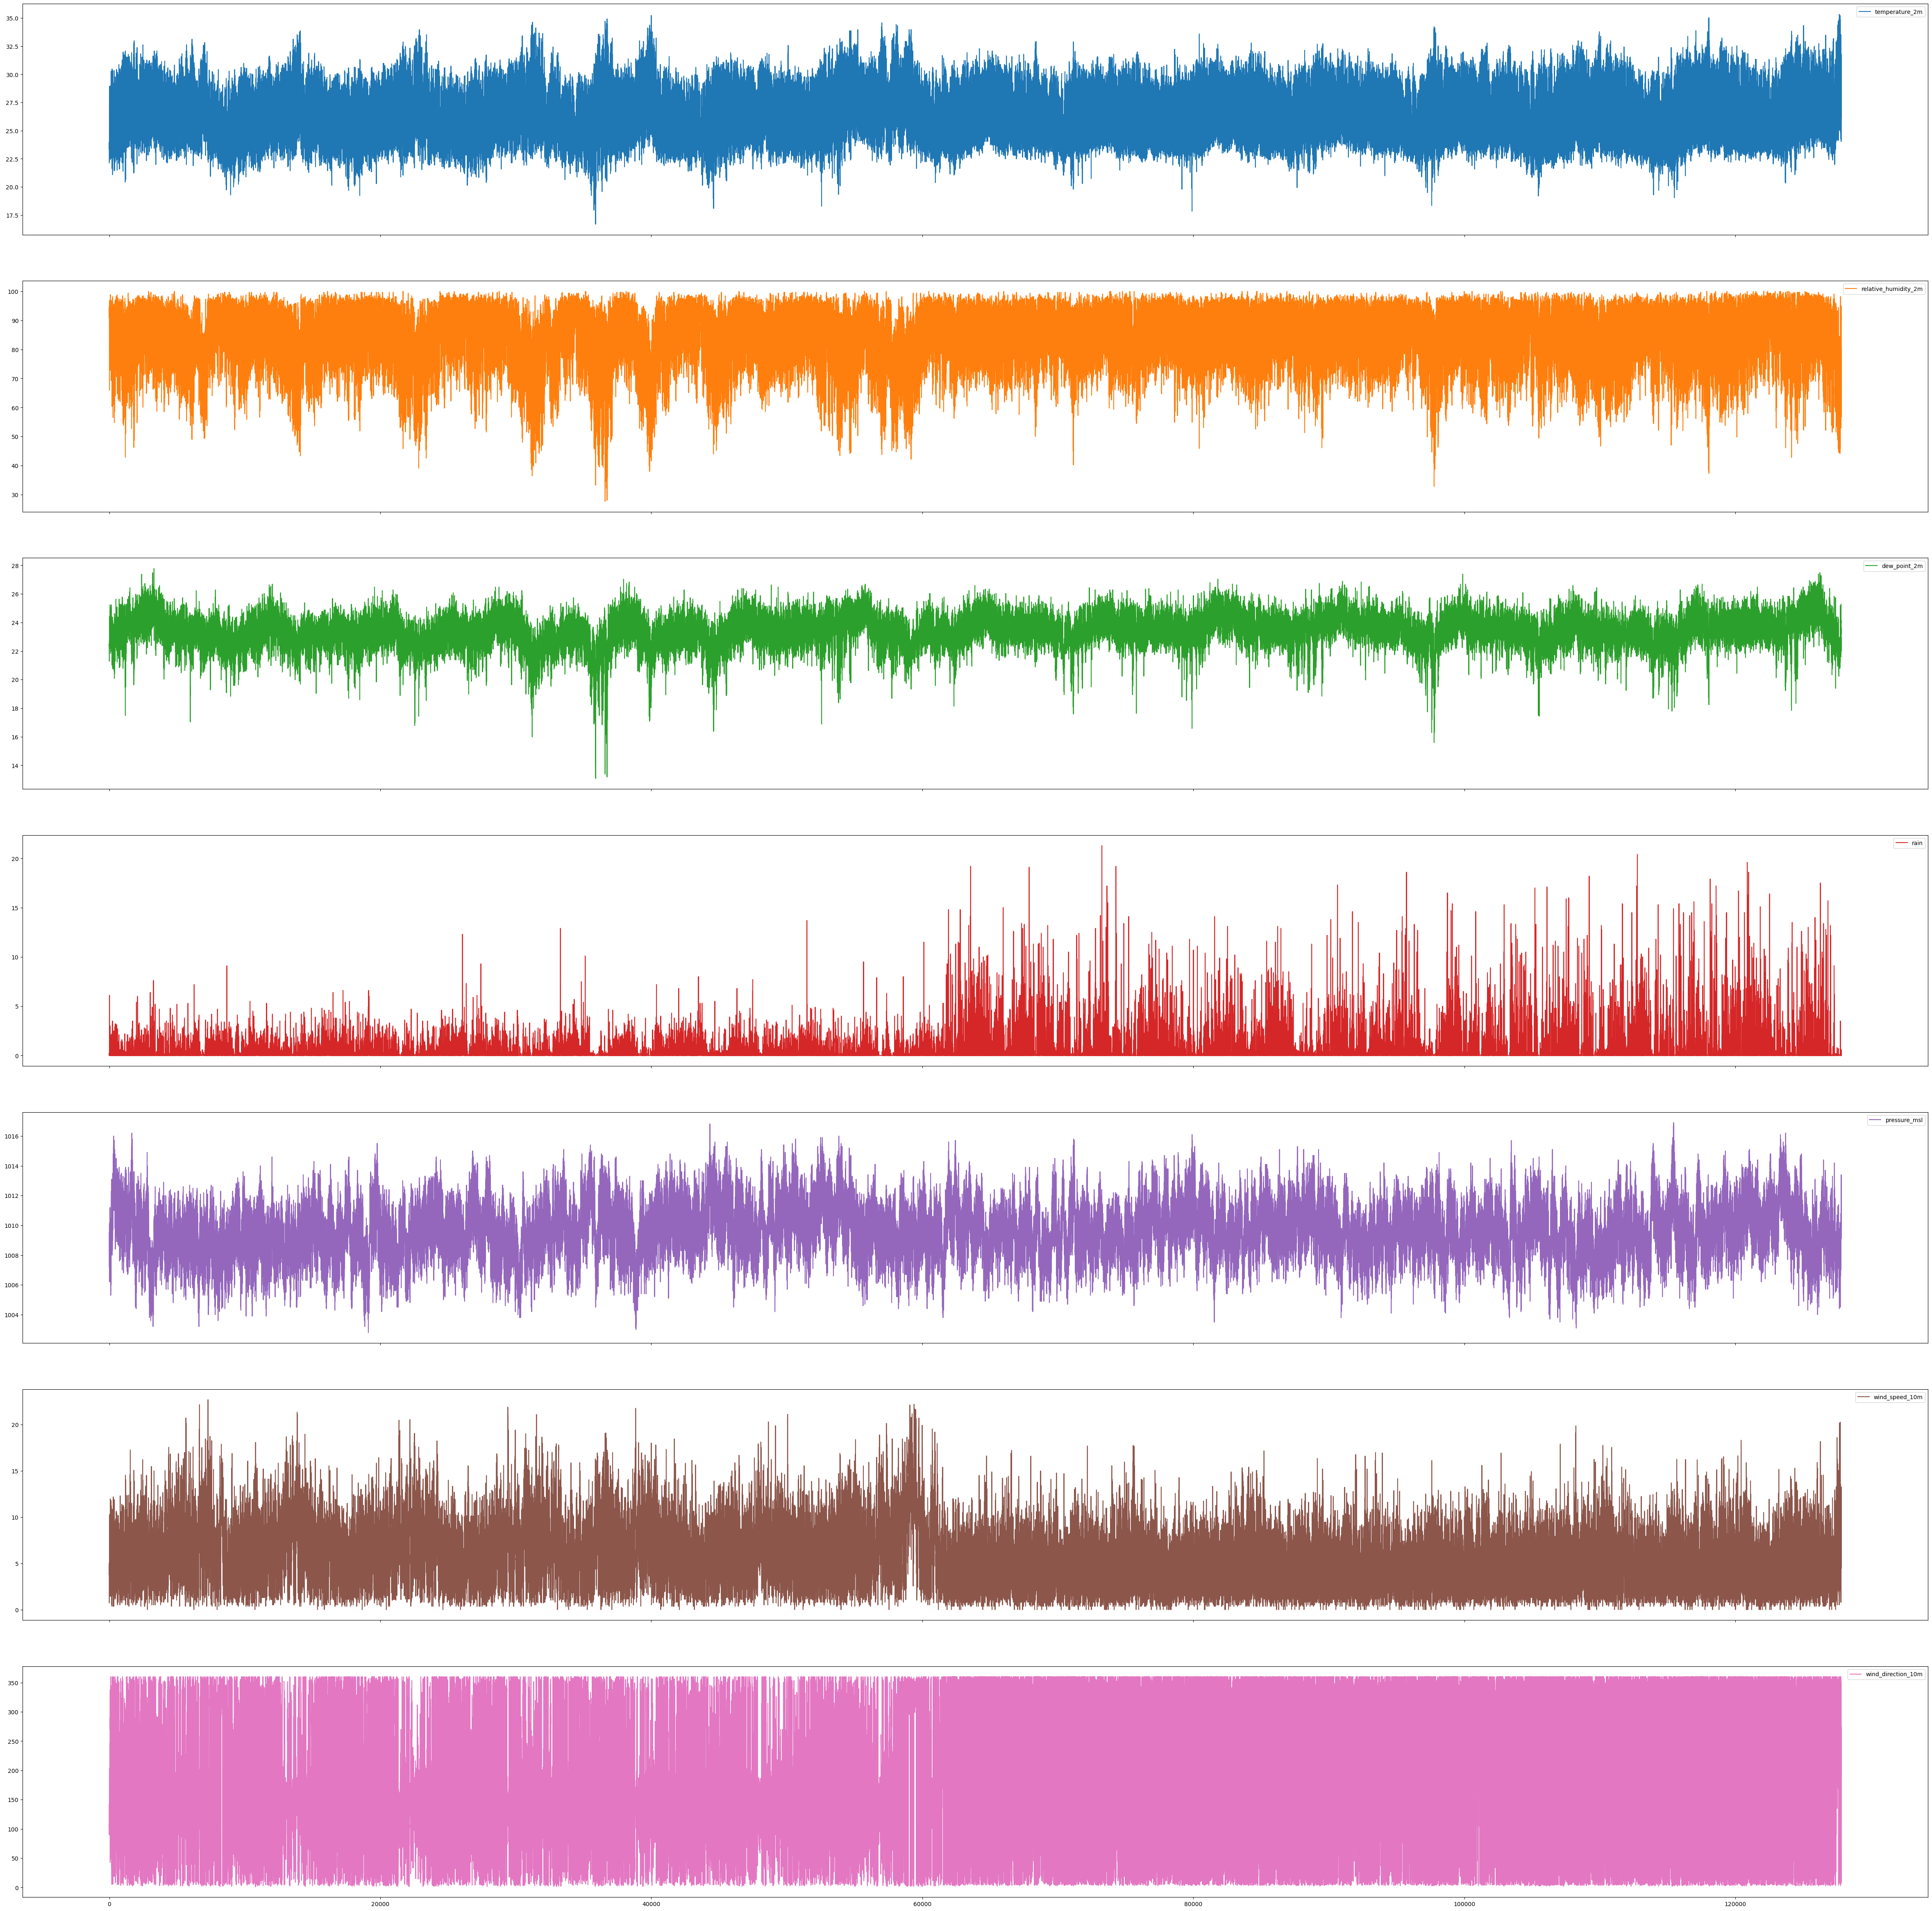

In [4]:
hourly_dataframe[['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m']].plot(subplots=True, figsize=(60, 60))

In [5]:
# Train Test split of 70-10-20 (train-eval-test) for LSTM training
training_size = int(0.70 * hourly_dataframe.shape[0])  
evaluation_size = int(0.10 * hourly_dataframe.shape[0])
testing_size = hourly_dataframe.shape[0] - training_size - evaluation_size

print("Training Size: ", training_size)
print("Evaluation Size: ", evaluation_size)
print("Testing Size: ", testing_size)
print("Total Size: ", hourly_dataframe.shape[0])

Training Size:  89476
Evaluation Size:  12782
Testing Size:  25566
Total Size:  127824


## Feature Selection Using Correlation Analysis

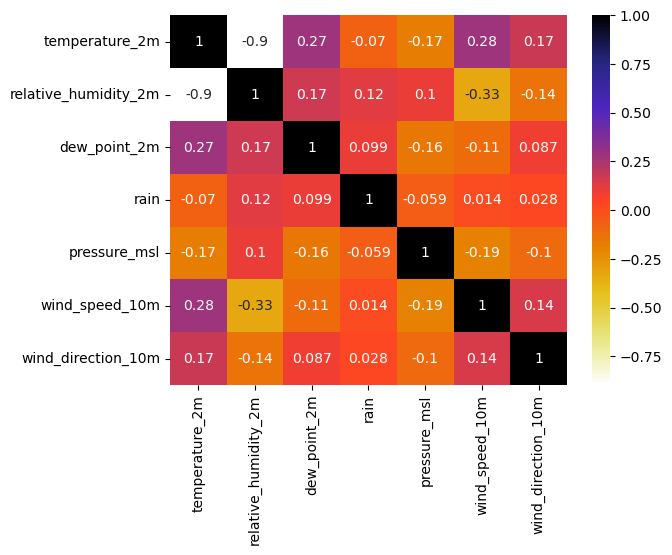

In [6]:
cor = hourly_dataframe.iloc[:training_size].drop(columns=['date']).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

## Splitting the dataset into the Training set and Test set

In [7]:
# final_hourly_dataframe = hourly_dataframe.drop(columns=['date', 'rain'])
# Set datetime as index
final_hourly_dataframe = hourly_dataframe.set_index('date')

In [8]:
hourly_dataframe.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m'],
      dtype='object')

In [9]:
# Splitting and preparing the train and test dataframes
# Function to convert data into sequences
def make_sequence(data, label_col, window_size =  72):

    sequences = []
    labels = []

    for i in range(data.shape[0] - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data.iloc[i+window_size])
        
    return np.array(sequences), np.array(labels)

In [10]:
training_dataset = final_hourly_dataframe.iloc[:training_size]
evaluation_dataset = final_hourly_dataframe.iloc[training_size:training_size+evaluation_size]
testing_dataset = final_hourly_dataframe.iloc[training_size+evaluation_size:]

training_dataset.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,rain,pressure_msl,wind_speed_10m,wind_direction_10m
date,,,,,,,
2009-12-31 16:00:00+00:00,23.382000,94.122230,22.382000,0.3,1009.5,3.758510,106.699326
2009-12-31 17:00:00+00:00,23.382000,94.122230,22.382000,0.0,1009.0,4.693825,94.398620
2009-12-31 18:00:00+00:00,23.581999,93.560814,22.481998,0.0,1008.7,4.680000,90.000000
2009-12-31 19:00:00+00:00,23.981998,90.782520,22.382000,0.2,1008.1,5.040000,90.000000
2009-12-31 20:00:00+00:00,23.632000,92.151920,22.282000,0.2,1007.7,3.758510,106.699326


## Feature Scaling

In [11]:
scaler = MinMaxScaler() # Default feature range [0, 1]

# Fit scalar to training dataset
scaled_training_dataset = pd.DataFrame(scaler.fit_transform(training_dataset), columns=training_dataset.columns)


# Scale the evaluation and testing datasets using the same training scaler
scaled_evalutation_dataset = pd.DataFrame(scaler.transform(evaluation_dataset), columns=evaluation_dataset.columns)
scaled_testing_dataset = pd.DataFrame(scaler.transform(testing_dataset), columns=testing_dataset.columns)


scaled_training_dataset.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,rain,pressure_msl,wind_speed_10m,wind_direction_10m
0,0.361186,0.918711,0.632653,0.014085,0.478571,0.165803,0.294141
1,0.361186,0.918711,0.632653,0.000000,0.442857,0.207063,0.259863
2,0.371968,0.910946,0.639456,0.000000,0.421429,0.206453,0.247605
3,0.393531,0.872523,0.632653,0.009390,0.378571,0.222334,0.247605
4,0.374663,0.891462,0.625850,0.009390,0.350000,0.165803,0.294141


In [12]:

# Create sequences for LSTM model for each type of dataset
X_train, y_train = make_sequence(scaled_training_dataset, 'temperature_2m')
X_eval, y_eval = make_sequence(scaled_evalutation_dataset, 'temperature_2m')
X_test, y_test = make_sequence(scaled_testing_dataset, 'temperature_2m')

In [13]:
# Print shapes of training
# Shape for X: (samples, time_steps, features)
# Shape for y: (samples, features)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_eval shape: ", X_eval.shape)
print("y_eval shape: ", y_eval.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (89404, 72, 7)
y_train shape:  (89404, 7)
X_eval shape:  (12710, 72, 7)
y_eval shape:  (12710, 7)
X_test shape:  (25494, 72, 7)
y_test shape:  (25494, 7)


In [ ]:
# Number of windows from n sized array with k window size, no +1 since we want the next predicted value
# n - k

## Create Model and Train

In [14]:
def create_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(LSTM(7)) # Predicting 7 features
    model.compile(optimizer='adam', loss='mse')
    return model

In [15]:
model = create_model((X_train.shape[1], X_train.shape[2]))

In [16]:
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_eval, y_eval), shuffle=False)

Epoch 1/50
1397/1397 [==============================] - 174s 119ms/step - loss: 0.0168 - val_loss: 0.0146
Epoch 2/50
1397/1397 [==============================] - 167s 120ms/step - loss: 0.0102 - val_loss: 0.0141
Epoch 3/50
1397/1397 [==============================] - 171s 122ms/step - loss: 0.0097 - val_loss: 0.0139
Epoch 4/50
1397/1397 [==============================] - 167s 120ms/step - loss: 0.0094 - val_loss: 0.0137
Epoch 5/50
1397/1397 [==============================] - 167s 120ms/step - loss: 0.0093 - val_loss: 0.0136
Epoch 6/50
1397/1397 [==============================] - 167s 120ms/step - loss: 0.0091 - val_loss: 0.0134
Epoch 7/50
1397/1397 [==============================] - 167s 119ms/step - loss: 0.0090 - val_loss: 0.0132
Epoch 8/50
1397/1397 [==============================] - 169s 121ms/step - loss: 0.0089 - val_loss: 0.0131
Epoch 9/50
1397/1397 [==============================] - 169s 121ms/step - loss: 0.0088 - val_loss: 0.0131
Epoch 10/50
1397/1397 [=======================

## Evaluate Model

In [20]:
test_precdictions = model.predict(X_test)

797/797 [==============================] - 36s 42ms/step


In [21]:
print(test_precdictions.shape)
print(test_precdictions[0])

(25494, 7)
[0.5881207  0.6889531  0.76985055 0.01158805 0.30491298 0.15837948
 0.49809706]


In [23]:
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, test_precdictions)
rmse = np.sqrt(mean_squared_error(y_test, test_precdictions))

print("Test data Mean Absolute Error: ", mae)
print("Test data Root Mean Squared Error: ", rmse)


Test data Mean Absolute Error:  0.04476640412244242
Test data Root Mean Squared Error:  0.0923024628912736


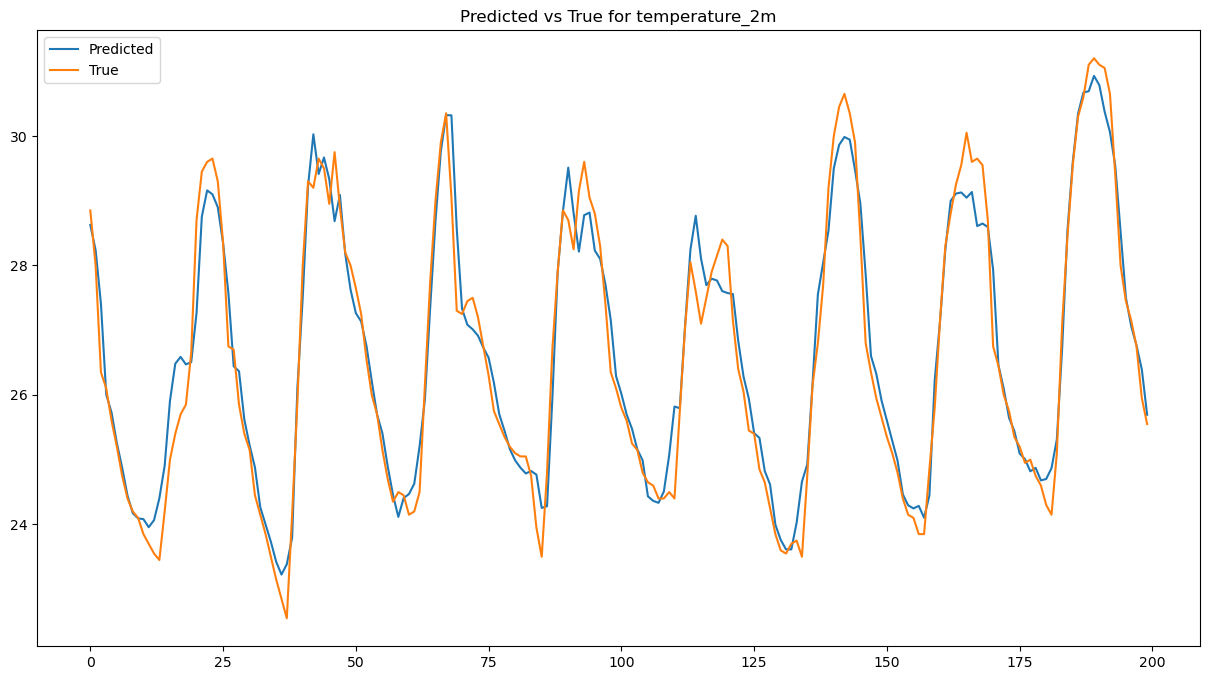

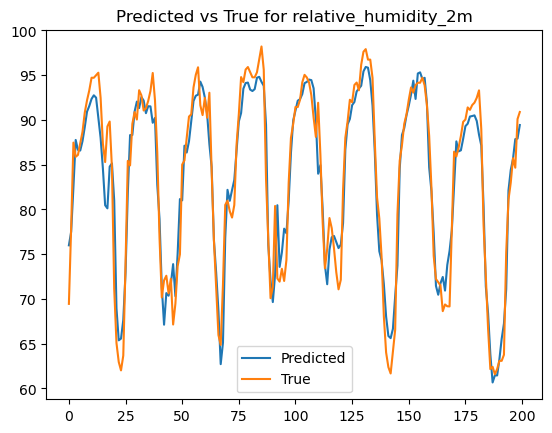

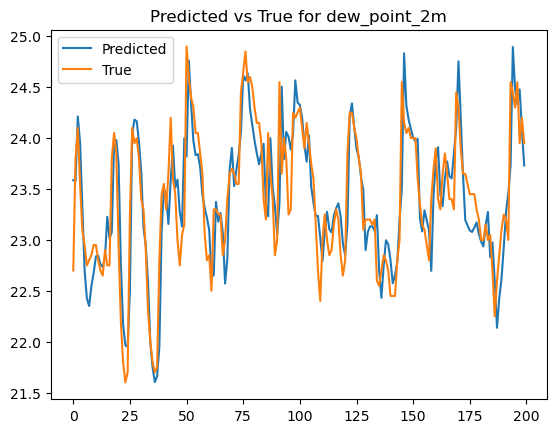

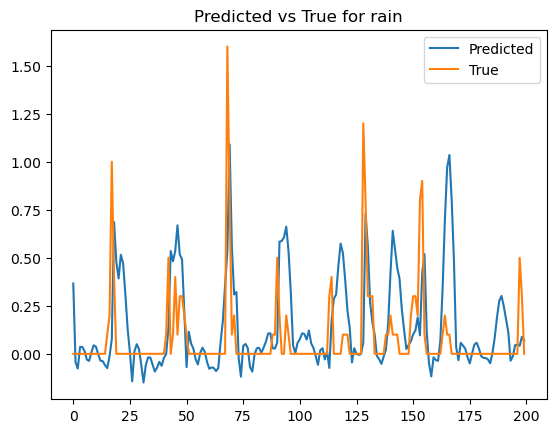

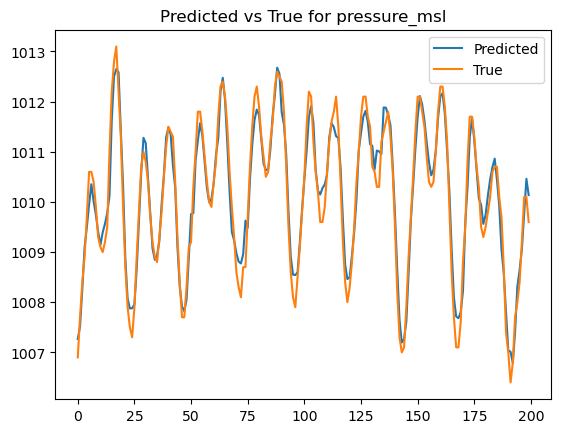

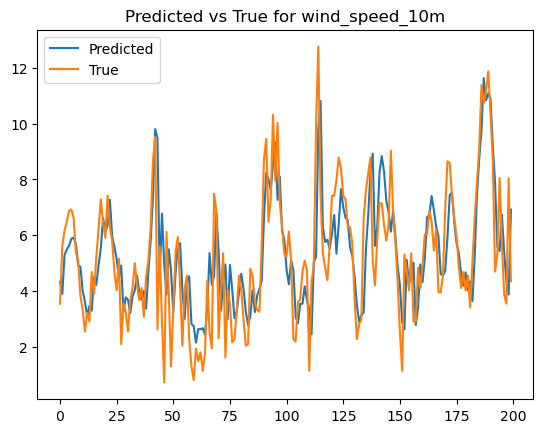

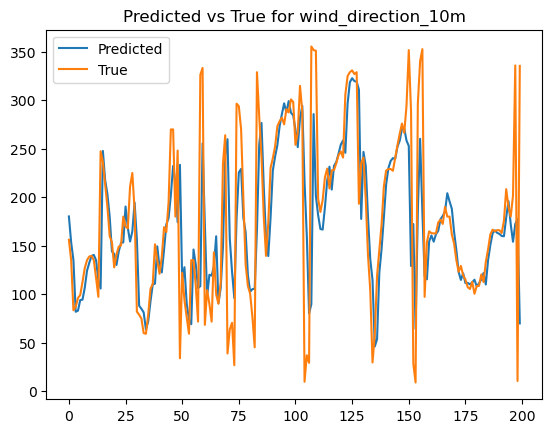

In [24]:
# Inverse transform the predictions and true values
transformed_test_predictions = scaler.inverse_transform(test_precdictions)
transformed_y_test = scaler.inverse_transform(y_test)

# Plot predicted values against true values
plt.figure(figsize=(15, 8))

# Only get the list of columns strings and exclude the first date column
columns = list(hourly_dataframe.columns)[1:]

# Plot for each attribute
for i in range(transformed_y_test.shape[1]):
    plt.plot(transformed_test_predictions[:200, i], label='Predicted')
    plt.plot(transformed_y_test[:200, i], label='True')
    plt.title(f'Predicted vs True for {columns[i]}')
    plt.legend()
    plt.show()

## Export Model and Scaler

In [25]:
model_location = f'../../models/{location_code}/model.h5'
scaler_location = f'../../models/{location_code}/scaler.pkl'


In [26]:
# Save LSTM model
model.save(model_location)

In [27]:
# Save MinMaxScaler object
joblib.dump(scaler, scaler_location)

['../../models/petaling-jaya/scaler.pkl']